## Creating MPRA result tables for all libraries

#### standard functions and packages

In [1]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random

import pandas as pd
import rpy2.rinterface as rinterface
import rpy2.robjects as robjects
import tqdm
import seaborn as sns
import scipy.stats as stats

from itertools import compress
from Bio import motifs
from Bio.Seq import Seq #, IUPAC
from collections import Counter
from os import listdir
from os.path import join
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from scipy.stats import ks_2samp
from statistics import mean, median

%load_ext rpy2.ipython

%matplotlib inline
pandas2ri.activate()
plt.ioff()

In [2]:
%%R
library(Biostrings)
library("BSgenome.Hsapiens.UCSC.hg19")
library(stringi)
library(rtracklayer)
library(ggplot2)
library(patchwork)
library(gplots)
library(RColorBrewer)
library(plotly)
library(reshape2)
library("wesanderson",lib.loc="/home/kribelba/R_libs/")
library(GenomicFeatures)
library("TxDb.Hsapiens.UCSC.hg19.knownGene")
library('AnnotationHub')
library(GO.db)
library(org.Hs.eg.db)
library(ChIPseeker)
library(ggpubr)

library(viridis)
library(tidyverse)
library(dplyr)
library(DESeq2)
library(Rsubread)
library("tximport")
library("readr")
library(biomaRt)
library(ggbeeswarm)
library(ggrepel)

# general functions
makeTr <- function(someColor, alpha=100) scales::alpha(someColor, alpha/100)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ ggplot2::Position()   masks BiocGenerics::Position(), base::Position()
✖ dplyr::collapse()     masks Biostrings::collapse(), IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ purrr::compact()      masks XVector::compact()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks plotly::filter(), stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::ident()        masks dbplyr::ident()
✖ dplyr::lag()          masks stats::lag()
✖ purrr::reduce()       masks GenomicRanges::reduce(), IRang

Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors
Loading required package: stats4

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    I, expand.grid, unname

Loading required package: IRanges
Loading required package: XVector
Loading required package: GenomeInfoDb

Attaching package: ‘

## Load raw count tables

In [3]:
%%R
# define indiviudal paths for count tables
pth3p8 = '/home/kribelba/updepla/users/kribelba/RMCE_results/RMCE_v6_3p8redo_PCR_optimization_spike_0606_2023'
pth3p98 = '/home/kribelba/updepla/users/kribelba/RMCE_results/RMCE_v6_3p9_3p8_redo_PCR_16to18cyc_13plus8BS_NXT1009_2023_07_14/count_data_final'
pth4p88 = '/home/kribelba/updepla/users/kribelba/RMCE_results/RMCE_v6_4p8_3p8_redo_PCR_16to18cyc_NXT1009_2023_07_14'
pth5p1 = '/home/kribelba/updepla/users/kribelba/RMCE_results/RMCE_v7_5p1_artificial_enh_16to18cyc_NXT1009_2023_07_14'
pth5p7 = '/home/kribelba/updepla/users/kribelba/RMCE_results/RMCE_v7_5p7_artificial_enh_47ins_wt_TATA_250del_refalt_lib_2023_11_03'
pth5p8 = '/home/kribelba/updepla/users/kribelba/RMCE_results/Pinello_lab_collab/data_tables'
list.files(pth3p8)

 [1] "Minion0022_short_insets_800to1000bp_BCs_tab_2023_06_14.csv"                             
 [2] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_16_8_7_cyc_gDNA_rep5_06_20_2023.csv"
 [3] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_16_8_7_cyc_gDNA_rep6_06_20_2023.csv"
 [4] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_16_8_7_cyc_mRNA_rep5_06_20_2023.csv"
 [5] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_16_8_7_cyc_mRNA_rep6_06_20_2023.csv"
 [6] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_20_8_7_cyc_gDNA_rep1_06_06_2023.csv"
 [7] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_20_8_7_cyc_gDNA_rep2_06_06_2023.csv"
 [8] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_20_8_7_cyc_mRNA_rep1_06_06_2023.csv"
 [9] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_20_8_7_cyc_mRNA_rep2_06_06_2023.csv"
[10] "redo_count_data_BC14bp_read1_flank_checked_RMCE_3p8_24_8_7_cyc_gDNA_rep3_06_06_2023.csv"
[11] "redo_count_data_BC14bp_read1_flank_checked_R

## function to load indiviudal counts across replicates

for each replicate the count data is in a two-column formatn (BC identity and corresponding count)

In [10]:
%%R

load_count_table = function(pth,rep_ids=c(1,2,3,4,5,6),name_filter,mRNAf='mRNA',gDNAf = 'gDNA'){
    
    # pth = path to count data
    # rep_ids = replicate numbers, as present in count data
    # name_filer = in case other files are in directory, specify which ones belong to the library of interest
    # mRNAf = filter by mRNA reps (contains mRNA in fastq file)
    # gDNAf = filter by gDNA reps (contains gDNA in fastq file)

    ll = list.files(pth,full.names=T)
    llf = ll[grep(name_filter,ll)]
    llr = llf[grep(mRNAf,llf)]
    lld = llf[grep(gDNAf,llf)]
    file_ord = paste0('rep',rep_ids)
    rna_files = llr[sapply(file_ord,function(x){grep(x,llr)})]
    dna_files = lld[sapply(file_ord,function(x){grep(x,lld)})]
    llo = c(dna_files,rna_files) # first all gDNAs reps and then all mRNA reps
    DFls = lapply(llo,function(x){read.csv(x,header=T)})
    ## all unique BC kmers
    ukmers = unique(unlist(lapply(DFls,function(x){x$index})))
    # make DF
    DFjc = do.call(cbind,lapply(DFls,function(x){x[match(ukmers,x$index),2:3]}))
    DFj = DFjc[,c(1,seq(2,2*length(llo),2))] # only the counts to keep
    colnames(DFj) = c('BC',paste0('gDNA_rep',rep_ids),paste0('mRNA_rep',rep_ids))
    # replace NA counts with 0
    for (i in 2:(2*length(rep_ids)+1)){
        DFj[is.na(DFj[,i]),i]=0}
    return(DFj)
}

In [11]:
%%R
df38 = load_count_table(pth3p8,rep_ids=c(1,2,3,4,5,6),'redo_count')
print(head(df38))

df39 = load_count_table(pth3p98,rep_ids=c(1,2,3,4,5,6,7,8),'redo_count')
print(head(df39))

df48 = load_count_table(pth4p88,rep_ids=c(1,2,3,4,5,7,8),'redo_count') #replicate 6 failed during amplification
print(head(df48))

df51 = load_count_table(pth5p1,rep_ids=c(1,2,4),'merged') # repl 3 lib prep failed in pre-sequencing QC
print(head(df51))

df57 = load_count_table(pth5p7,rep_ids=c(1,2,3,4,5),'count_data')
print(head(df57))

df58 = load_count_table(pth5p8,rep_ids=c(1,2,3,4,5),'count_data')
print(head(df58))



              BC gDNA_rep1 gDNA_rep2 gDNA_rep3 gDNA_rep4 gDNA_rep5 gDNA_rep6
1 AACCCTACGCCCCG       112       166       203        57       137        60
2 GACGATTATCAGTC      2381      1872      2595      2816      1132      1208
3 ACTTGGGCGACAAC      1017       796      1338      1377       296       439
4 TTTCTGTCTGGAAT      1027       685      1389      1212       550       548
5 CAGCCCTAGAACAC      4785      4759      5820      5528      2174      2054
6 ACTGCATTCCGATA      1906      1911      2393      2324       770       858
  mRNA_rep1 mRNA_rep2 mRNA_rep3 mRNA_rep4 mRNA_rep5 mRNA_rep6
1         0         0         0         0         0         0
2      2958      3591      1650      2617       887      2090
3      3184      2244      3338      3784      1286       799
4      1576      2031      2091      2293       821      1039
5      7238      8171      6528     10138      3731      2013
6         0         0         0         0         0         0
              BC gDNA_rep1 

## match barcodes to fragments via Nanopore mapping files

In [13]:
%%R
map38 = read.csv('/home/kribelba/updepla/users/kribelba/RMCE_results/EMPERA_paper_results_2023_NOV/BC_maps/2024_05_27/JK_processing/lib3p8_BC_TF_nanopore_count_table_unique_BC_seq_and_3xover_secondarymatch_filtered_by_14bpBCseq_and_aligendReference_TFmatching_2024_06_07.csv',header=T)
#print(head(map38))

map39 = read.csv('/home/kribelba/updepla/users/kribelba/RMCE_results/EMPERA_paper_results_2023_NOV/BC_maps/2024_05_27/JK_processing/lib3p9_BC_TF_nanopore_count_table_unique_BC_seq_and_3xover_secondarymatch_filtered_by_14bpBCseq_and_aligendReference_TFmatching_2024_06_10.csv',header=T)
#print(head(map39))
map48 = read.csv('/home/kribelba/updepla/users/kribelba/RMCE_results/EMPERA_paper_results_2023_NOV/BC_maps/2024_05_27/JK_processing/lib4p8_BC_TF_nanopore_count_table_unique_BC_seq_and_3xover_secondarymatch_filtered_by_14bpBCseq_and_aligendReference_TF_IBTWmatching_2024_06_11.csv',header=T)
#print(head(map48))

map51 = read.csv('/home/kribelba/updepla/users/kribelba/RMCE_results/EMPERA_paper_results_2023_NOV/BC_maps/2024_05_27/JK_processing/lib5p1_BC_TF_nanopore_count_table_unique_BC_seq_and_3xover_secondarymatch_filtered_by_12bpBCseq_and_aligendReference_TF_IBTWmatching_2024_07_30.csv',header=T)
print(head(map51))

map57 = read.csv('/home/kribelba/updepla/users/kribelba/RMCE_results/EMPERA_paper_results_2023_NOV/BC_maps/2024_05_27/JK_processing/lib5p7_BC_TF_nanopore_count_table_unique_BC_seq_and_3xover_secondarymatch_filtered_by_12bpBCseq_and_aligendReference_TF_IBTWmatching_2024_08_03.csv',header=T)
print(head(map57))
print(dim(map57))

# for library 5.7 we did a more stringent filterint, since many TFBS can occurr in more than one of the synthetic enhancers. There is no major difference between the regular and stringent BC-to-enhancer mapping filtering when it comes to syn enhancer-specific downstream logFC values.
map57xf = read.csv('/home/kribelba/updepla/users/kribelba/RMCE_results/EMPERA_paper_results_2023_NOV/BC_maps/2024_05_27/JK_processing/lib5p7_BC_TF_nanopore_count_table_unique_BC_seq_and_3xover_secondarymatch_filtered_by_12bpBCseq_and_aligendReference_TF_IBTWmatching_and_flank_matching_2024_09_12.csv',header=T)
print(head(map57xf))
print(dim(map57xf))

map58 = read.csv('/home/kribelba/updepla/users/kribelba/RMCE_results/EMPERA_paper_results_2023_NOV/BC_maps/2024_05_27/JK_processing/lib5p8_BC_TF_nanopore_count_table_unique_BC_seq_and_3xover_secondarymatch_filtered_by_12bpBCseq_and_aligendReference_TF_IBTWmatching_2024_08_23.csv',header=T)
print(head(map58))
print(dim(map58))


                     x Freq           BC
1      MF2A_PU1_CTCFin   16 AAACACGAGTTT
2 CGisland_del_enh_del   33 AAACATTGGGCA
3    MF2A_SPI1_FX1_BH1    4 AAACGACACGTC
4     MF2A_PU1_CTCFout   11 AAAGAAACTGCG
5        MF2A_PU1_TF65   42 AAAGGAGGGTAG
6        MF2A_PU1_MF2A   25 AAAGGTCGAGAT
                           x Freq           BC
1       TATAins-FX1_BATF_FX1    6 AAAAAAAAGGCA
2          wt-IRF2_IRF2_IRF2    4 AAAAAATGGTGC
3  CGislandDel-MF2A_PU1_TF65   46 AAAAACATATAA
4                    wt-RELB   24 AAAAACCTGTAG
5 CGislandDel-RUNX3_PU1_TF65   20 AAAAACGGTGAG
6      wt-MF2A_SPI1_FX1_TF65    5 AAAAACGTGTTG
[1] 773719      3
                      x Freq           BC
1  TATAins-FX1_BATF_FX1    4 AAAAAAAAGGCA
2               wt-RELB   16 AAAAACCTGTAG
3 TATAins-MF2A_PU1_TF65    3 AAAAAGCGAGTT
4   TATAins-AHR_AHR_AHR   19 AAAAAGGAGTGA
5          TATAins-RELB   99 AAAAAGGCGACC
6           TATAins-FX1   21 AAAAAGGTTGTC
[1] 492297      3
                                                      

In [14]:
%%R

# function to map BCs to specific enhancer/Promoter modifications

map_BC_to_seq = function(df,mapbc){
    dfn=df
    dfn$seq = mapbc$x[match(df$BC,as.character(reverseComplement(DNAStringSet(mapbc$BC))))]
    dfn$nanoFreq = mapbc$Freq[match(df$BC,as.character(reverseComplement(DNAStringSet(mapbc$BC))))]
    
    return(dfn[!is.na(dfn$seq),])}


In [15]:
%%R


df38f = map_BC_to_seq(df38,map38)
print(head(df38f))

## lib 3p98 (includes 3p8 lib during experiment)
bad_BC398 = intersect(map39$BC,map38$BC) # since plasmid libraries 38 and lib 39 were run on Nanopores and mapped separately, we remove all BCs that independently occurred in both libs to avoid confoudning of mappings 
print(length(bad_BC398))
df39f = map_BC_to_seq(df39,rbind(map39[!(map39$BC %in% bad_BC398),],map38[!(map38$BC %in% bad_BC398),]))
print(head(df39f))

## lib 4p88 (includes 3p8 lib during experiment)
bad_BC488 = intersect(map38$BC,map48$BC) # same as above 
print(length(bad_BC488))
df48f = map_BC_to_seq(df48,rbind(map48[!(map48$BC %in% bad_BC488),],map38[!(map38$BC %in% bad_BC488),]))
print(head(df48f))

## lib 5p1
df51f = map_BC_to_seq(df51,map51)
print(head(df51f))

# lib 5p7 
df57f = map_BC_to_seq(df57,map57)
print(head(df57f))

# lib 5p7  extra filtering
df57xf = map_BC_to_seq(df57,map57xf)
print(head(df57xf))


# lib 5p8
df58f = map_BC_to_seq(df58,map58)
print(head(df58f))



               BC gDNA_rep1 gDNA_rep2 gDNA_rep3 gDNA_rep4 gDNA_rep5 gDNA_rep6
3  ACTTGGGCGACAAC      1017       796      1338      1377       296       439
4  TTTCTGTCTGGAAT      1027       685      1389      1212       550       548
5  CAGCCCTAGAACAC      4785      4759      5820      5528      2174      2054
11 GAACAAACGAAGGC       775       659      1011      1053       256       349
14 CCTTTGAGCAACAC      1402      1406      2103      2068       645       654
15 TTTTTATCGAATAT       143       137       301       157        77        97
   mRNA_rep1 mRNA_rep2 mRNA_rep3 mRNA_rep4 mRNA_rep5 mRNA_rep6   seq nanoFreq
3       3184      2244      3338      3784      1286       799   PU1      183
4       1576      2031      2091      2293       821      1039 NFKB1       67
5       7238      8171      6528     10138      3731      2013   ALT      121
11       767       932       358       698       277       256 MEF2B       81
14      1427      1226      1727      2511       592      1890 N

In [19]:
%%R
print(head(df38f))

               BC gDNA_rep1 gDNA_rep2 gDNA_rep3 gDNA_rep4 gDNA_rep5 gDNA_rep6
3  ACTTGGGCGACAAC      1017       796      1338      1377       296       439
4  TTTCTGTCTGGAAT      1027       685      1389      1212       550       548
5  CAGCCCTAGAACAC      4785      4759      5820      5528      2174      2054
11 GAACAAACGAAGGC       775       659      1011      1053       256       349
14 CCTTTGAGCAACAC      1402      1406      2103      2068       645       654
15 TTTTTATCGAATAT       143       137       301       157        77        97
   mRNA_rep1 mRNA_rep2 mRNA_rep3 mRNA_rep4 mRNA_rep5 mRNA_rep6   seq nanoFreq
3       3184      2244      3338      3784      1286       799   PU1      183
4       1576      2031      2091      2293       821      1039 NFKB1       67
5       7238      8171      6528     10138      3731      2013   ALT      121
11       767       932       358       698       277       256 MEF2B       81
14      1427      1226      1727      2511       592      1890 N

In [20]:
%%R

ctnames = c('df388','df398','4df88','df51','df57','df58','df57xf')
dfs = list(df38f,df39f,df48f,df51f,df57f,df58f,df57xf)
#1:length(ctnames)
for (i in c(length(ctnames)) ){
    write.csv(dfs[[i]],paste0('/outpath/raw_unfiltered_count_table',ctnames[i],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    
}



In [26]:
%%R
print(head(dfs[[1]]))
print(dim(dfs[[2]]))
ctnames = c('df388','df398','4df88','df51','df57','df58','df57xf')

write.csv(dfs[[1]],paste0('/outpath/raw_unfiltered_count_table',ctnames[1],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    
write.csv(dfs[[2]],paste0('/outpath/raw_unfiltered_count_table',ctnames[2],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    
write.csv(dfs[[3]],paste0('/outpath/raw_unfiltered_count_table',ctnames[3],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    
write.csv(dfs[[4]],paste0('/outpath/raw_unfiltered_count_table',ctnames[4],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    
write.csv(dfs[[5]],paste0('/outpath/raw_unfiltered_count_table',ctnames[5],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    
write.csv(dfs[[6]],paste0('/outpath/raw_unfiltered_count_table',ctnames[6],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    
write.csv(dfs[[7]],paste0('/outpath/raw_unfiltered_count_table',ctnames[7],'_all_reps_annotated_2025_01_10.csv'),row.names=FALSE)    


               BC gDNA_rep1 gDNA_rep2 gDNA_rep3 gDNA_rep4 gDNA_rep5 gDNA_rep6
3  ACTTGGGCGACAAC      1017       796      1338      1377       296       439
4  TTTCTGTCTGGAAT      1027       685      1389      1212       550       548
5  CAGCCCTAGAACAC      4785      4759      5820      5528      2174      2054
11 GAACAAACGAAGGC       775       659      1011      1053       256       349
14 CCTTTGAGCAACAC      1402      1406      2103      2068       645       654
15 TTTTTATCGAATAT       143       137       301       157        77        97
   mRNA_rep1 mRNA_rep2 mRNA_rep3 mRNA_rep4 mRNA_rep5 mRNA_rep6   seq nanoFreq
3       3184      2244      3338      3784      1286       799   PU1      183
4       1576      2031      2091      2293       821      1039 NFKB1       67
5       7238      8171      6528     10138      3731      2013   ALT      121
11       767       932       358       698       277       256 MEF2B       81
14      1427      1226      1727      2511       592      1890 N

## load annotated count data for lib 4p9 
This library was mapped manually as it only contained 2 enhancer variations and exact matches could be extracted.

In [10]:
%%R
df49f = read.csv('/path/BC_count_tab_lib_4p9_fragment_and_nanoFreq_assigned_2024_09_18.csv',header=T)
colnames(df49f)[grep('TF',colnames(df49f))] = 'seq'
print(head(df49f))


          BC gDNA_rep1 gDNA_rep2 gDNA_rep3 gDNA_rep4 mRNA_rep1 mRNA_rep2
1 CCCGTTCGCA        66         0         0         0         0         0
2 TGGGTGCATG        55        29         8        19         0         0
3 ACAAAGGCCC       237       487       543       205      1397         0
4 TCCCCCCTCT       120       118       145        74         0         0
5 CACGTACAGC        67       249        94        76       428      1361
6 CTGGGCCCCC       167       287       290        19         1       467
  mRNA_rep3 mRNA_rep4 seq nanoFreq
1         0         0 ALT        1
2         0         0 REF        6
3      1377      1860 REF        2
4         0       463 REF        2
5      2775       159 ALT       13
6       174       282 REF       14


# Pre-processing of count table

### two steps
1. Set all mRNA counts to zero that are zero in gDNA
2. dismiss barcodes with less than X counts across replicates

In [11]:
%%R
zero_handling = function(dfn,gdna_cid,nrep){
    df=dfn
    for (i in gdna_cid){
        df[which(df[,i]==0),i+nrep]=0}
    return(df)}

remove_lowBCs = function(df,gdna_cid,cut){
    return(df[which(rowSums(df[,gdna_cid])>=cut),])}
                         

              



## MPRA analysis

In [12]:
%%R
library(mpra)


# the treatn funciton is modified from the limma package to extract the SE 

treatn <- function(fit, lfc=log2(1.2), trend=FALSE, robust=FALSE, winsor.tail.p=c(0.05,0.1))
#	Moderated t-statistics relative to a logFC threshold.
#	Davis McCarthy, Gordon Smyth
#	25 July 2008.  Last revised 12 Apr 2020.
{
#	Check fit
	if(!is(fit,"MArrayLM")) stop("fit must be an MArrayLM object")
	if(is.null(fit$coefficients)) stop("coefficients not found in fit object")
	if(is.null(fit$stdev.unscaled)) stop("stdev.unscaled not found in fit object")
	fit$lods <- NULL

	coefficients <- as.matrix(fit$coefficients)
	stdev.unscaled <- as.matrix(fit$stdev.unscaled)
	sigma <- fit$sigma
	df.residual <- fit$df.residual
	if (is.null(coefficients) || is.null(stdev.unscaled) || is.null(sigma) || 
		is.null(df.residual)) 
		stop("No data, or argument is not a valid lmFit object")
	if (max(df.residual) == 0) 
		stop("No residual degrees of freedom in linear model fits")
	if (!any(is.finite(sigma))) 
		stop("No finite residual standard deviations")
	if(trend) {
		covariate <- fit$Amean
		if(is.null(covariate)) stop("Need Amean component in fit to estimate trend")
	} else {
		covariate <- NULL
	}
	sv <- squeezeVar(sigma^2, df.residual, covariate=covariate, robust=robust, winsor.tail.p=winsor.tail.p)
	fit$df.prior <- sv$df.prior
	fit$s2.prior <- sv$var.prior
	fit$s2.post <- sv$var.post
	df.total <- df.residual + sv$df.prior
	df.pooled <- sum(df.residual,na.rm=TRUE)
	df.total <- pmin(df.total,df.pooled)
	fit$df.total <- df.total
	lfc <- abs(lfc)
	acoef <- abs(coefficients)
	se <- stdev.unscaled*sqrt(fit$s2.post)
	tstat.right <- (acoef-lfc)/se
	tstat.left <- (acoef+lfc)/se
	fit$t <- array(0,dim(coefficients),dimnames=dimnames(coefficients))
	fit$p.value <- pt(tstat.right, df=df.total,lower.tail=FALSE) + pt(tstat.left,df=df.total,lower.tail=FALSE)
    fit$SE = se # extract SE!
	tstat.right <- pmax(tstat.right,0)
	fc.up <- (coefficients > lfc)
	fc.down <- (coefficients < -lfc)
	fit$t[fc.up] <- tstat.right[fc.up]
	fit$t[fc.down] <- -tstat.right[fc.down]
	fit$treat.lfc <- lfc
	fit
}


create_MPRA_tab_simple = function(DF,nrep,seq_cid,rep_ids){
    # this function takes the count tables with BC-fragment mappings and aggregates counts across BCs for each fragment
        # nrep = number of replicates
        # seq_cid = column id that contains fragment id
        # rep_ids = replicate column ids to include in fit
    rna = DF[,(nrep+2):(2*nrep+1)][,rep_ids]
    dna = DF[,2:(nrep+1)][,rep_ids]
    rownames(rna)=paste0(DF$BC,".",DF[,seq_cid])
    rownames(dna)=paste0(DF$BC,".",DF[,seq_cid])
    colnames(rna)=paste0('rep_',rep_ids)
    colnames(dna)=paste0('rep_',rep_ids)
    
    ## aggregate
    tfs=unique(DF[,seq_cid])
    
    aggs_rna2 =(lapply(tfs,function(pattern){ 
        bool_rna <- DF[,seq_cid] %in% pattern
        colSums(rna[bool_rna,])}))
    aggs_dna2 =(lapply(tfs,function(pattern){ 
        bool_dna <- DF[,seq_cid] %in% pattern
        colSums(dna[bool_dna,])}))
    agg_rna = do.call(rbind,aggs_rna2)
    rownames(agg_rna)=tfs
    agg_dna = do.call(rbind,aggs_dna2)
    rownames(agg_dna)=tfs
    return(list(agg_dna,agg_rna))}

get_mpra_result_mod=function(mpralist,cid){
    # fit mpralm on aggregate count matrices
        # include SE extraction from fit
    
    mpraset <- MPRASet(DNA = mpralist[[1]], 
                   RNA = mpralist[[2]], 
                   eid = rownames(mpralist[[2]]), 
                   eseq = NULL, 
                   barcode = NULL)

    design <- model.matrix(~1, data=data.frame(sample=paste0('rep_',cid)))

    fit <- mpralm(object = mpraset, design = design, aggregate = "none",
              normalize = FALSE, model_type = "indep_groups", plot = TRUE)

    tr <- treatn(fit, lfc=1)
    #print(tr)
    mpra_result <- topTreat(tr, coef = 1, number = Inf)
    mpra_result$uid=rownames(mpra_result)
    mpra_result$stdev.unscaled = fit$stdev.unscaled[match(mpra_result$uid,rownames(fit$stdev.unscaled))]
    mpra_result$SE = tr$SE
    colnames(mpra_result)[length(mpra_result[1,])]='SE'
   return(mpra_result)
}

Loading required package: limma

Attaching package: ‘limma’

The following object is masked from ‘package:DESeq2’:

    plotMA

The following object is masked from ‘package:BiocGenerics’:

    plotMA



In [ ]:
%%R
## aggregate tables

mpra38 = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df38f,c(2:7),6),c(2:7),10),6,which(colnames(df38f)=='seq'),c(1:6))
mpra39 = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df39f,c(2:9),8),c(2:5,8:9),10),8,which(colnames(df39f)=='seq'),c(1:4,7:8))

mpra48 = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df48f,c(2:8),7),c(2:5,7:8),10),7,which(colnames(df48f)=='seq'),c(1:4,6:7))

mpra51 = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df51f,c(2:4),3),c(2:4),10),3,which(colnames(df51f)=='seq'),c(1:3))

mpra57 = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df57f,c(2:6),5),c(2:6),10),5,which(colnames(df57f)=='seq'),c(1:5))
mpra57xf = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df57xf,c(2:6),5),c(2:6),10),5,which(colnames(df57xf)=='seq'),c(1:5))

mpra58 = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df58f,c(2:6),5),c(2:6),10),5,which(colnames(df58f)=='seq'),c(1:5))

# fit mpralm results

mpra_res38 = get_mpra_result_mod(mpra38,c(1:6))
mpra_res39 = get_mpra_result_mod(mpra39,c(1:4,7:8)) # rep 5 and 6 were low quality (from pre-seq QC and dropped)
mpra_res48 = get_mpra_result_mod(mpra48,c(1:4,6:7)) # rep 5 was low quality (from pre-seq QC and dropped)

mpra_res51 = get_mpra_result_mod(mpra51,1:3)
mpra_res57 = get_mpra_result_mod(mpra57,1:5)
mpra_res57xf = get_mpra_result_mod(mpra57xf,1:5)
mpra_res58 = get_mpra_result_mod(mpra58,1:5)


       logFC  AveExpr         t    P.Value  adj.P.Val uid stdev.unscaled
ALT 1.987652 2.021390 2.6777069 0.01841895 0.03683789 ALT      0.3776807
REF 1.311720 1.359011 0.8696516 0.20928811 0.20928811 REF      0.3670318
    (Intercept)
ALT   0.3688426
REF   0.3584429


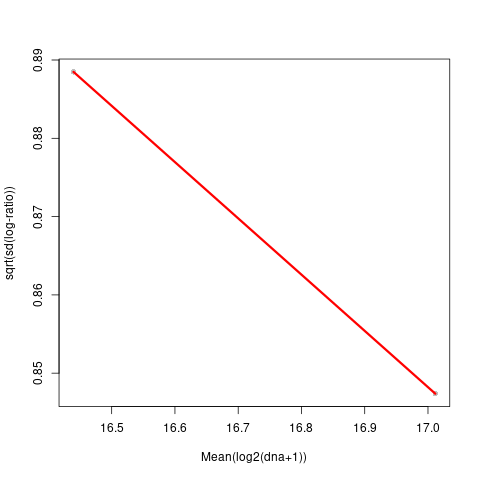

In [18]:
%%R
# for 4p9 lib REF/ALT only
mpra49 = create_MPRA_tab_simple(remove_lowBCs(zero_handling(df49f,c(2:5),4),c(2:5),10),4,which(colnames(df49f)=='seq'),c(1:4))
mpra_res49 = get_mpra_result_mod(mpra49,c(1:4)) 
print(head(mpra_res49))

## Save to file

In [19]:
%%R
ctnames = c('3p88','3p98','4p88','5p1','5p7','5p8','5p7xf','4p9')
mtabs = list(mpra_res38,mpra_res39,mpra_res48,mpra_res51,mpra_res57,mpra_res58,mpra_res57xf,mpra_res49)
#1:length(ctnames)
for (i in c(length(ctnames)) ){
    write.csv(mtabs[[i]],paste0('/outpath/SE_extracted_MPRA_fit_res_lib_',ctnamest[i],'_filtered_mRNA0forgDNA0_minCountAcrossGDnaReps10_2024_09_13.csv'),row.names=FALSE)    
}

# STARR seq data for 3p98 and 5p7 artifical enhancers

### 21 BS Axin2 enhancer starr-seq
Starting from the indiviudal count tables and assembling the mapping

In [22]:
%%R
DFplc= read.csv('/path/count_data_BC12_flank_checked_Ax2E_35_BS26_plDNA_2022_05_23.csv',header=T)
DFr1c= read.csv('/path/count_data_BC12_flank_checked_Ax2E_35_BS26_mRNA_rep1_2022_05_23.csv',header=T)
DFr2c= read.csv('/path/count_data_BC12_flank_checked_Ax2E_35_BS26_mRNA_rep2_2022_05_23.csv',header=T)

print(head(DFr2c))
kmers = intersect(DFplc$index,intersect(DFr1c$index,DFr2c$index))
length(kmers)

DFj = data.frame(kmer = kmers,plDNA_raw = DFplc$X0[match(kmers,DFplc$index)],
                RNA_raw1 = DFr1c$X0[match(kmers,DFr1c$index)], RNA_raw2 = DFr2c$X0[match(kmers,DFr2c$index)])

DFj$BCrc = as.character(reverseComplement(DNAStringSet(DFj$kmer)))
print(head(DFj))


  X        index   X0
1 0 CTTAATGCTTTT  135
2 1 GCTGTTTCTTTG  331
3 2 TTTTTGCTATTC  162
4 3 GAAGGGCCCAAT  165
5 4 TTCTGACAAGTT 1182
6 5 CCTTTTAGTATA  151
          kmer plDNA_raw RNA_raw1 RNA_raw2         BCrc
1 GTTTCAACCTCA       315      583      304 TGAGGTTGAAAC
2 GTGTTTTTAGAC       728      678      334 GTCTAAAAACAC
3 TGGAAGTCAAAT       370      842      443 ATTTGACTTCCA
4 TTGTGAATTTCA       277      349      171 TGAAATTCACAA
5 TTCTCTGAGGAC       235      380      203 GTCCTCAGAGAA
6 CGTCTCAGGCTG       452     1842      937 CAGCCTGAGACG


In [6]:
%%R
# load nanopore mapping
map_BC_BSref = read.csv('/path_to_nanopore_BS_BC_map_lib3p5/BC_BS_mapping_REFspecific_35_NheI_SalI_cut_nano_2022_05_31.csv',header=T)

map_BC_BSref$BS_len = sapply(as.character(map_BC_BSref$BS_seq),nchar)
map_BC_BSref$BCrc = as.character(reverseComplement(DNAStringSet(map_BC_BSref$BC_seq)))

print(head(map_BC_BSref))


# load BS information
BS_info = read.csv('/path_to_BS_info_file/RMCE_26BS_lib.csv',header=T)
print(head(BS_info,n=5))
BS_info$BS = sapply(1:length(BS_info[,1]),function(x){strsplit(BS_info$seq[x],split=" ")[[1]][2]})

print(BS_info$TF)
BS8_info = BS_info[BS_info$TF %in% c('ALT','CTCF','IRF2','MEF2B','FOSL1','NFKB1','PU1','REF'),]
BS13_info = BS_info[BS_info$TF %in% c("ALT_rc","BATF","BC11A","EGR1","ELF1","FEV","IRF2_rc","MEF2A","NFIA","PU1_2for","PU1_2fr","RUNX1","SP2_short"),]
print(head(BS8_info,n=8))
head(BS13_info)
print(max(sapply(BS_info$BS,nchar)))

  X       BC_seq                   BS_seq dist_BC_BS BS_len         BCrc
1 0 GAGTTCGTTTGG        AAAAGAGGAAATGAAAA        446     17 CCAAACGAACTC
2 1 ACTACTCACGTT            GGCCGCCGGCGCC        445     13 AACGTGAGTAGT
3 2 AGTGACTGTTGG AGAGGAAGTGAATAGAGGAAGTGA        432     24 CCAACAGTCACT
4 3 GCGAATGTAGTA              AGAGGAAGTGA        443     11 TACTACATTCGC
5 4 AAATTTTCTTGG            GGGGGGCGGGGCC        440     13 CCAAGAAAATTT
6 5 TTTTGCTTGGTA            TTTAAAAAAATTT        438     13 TACCAAGCAAAA
  No    TF
1  1 FOSL1
2  2 MEF2B
3  3  NFIA
4  4 NFKB1
5  5 MEF2A
                                                                                          seq
1     CACAATGTGGGGGGTGGGGGAGAGAGAAAAATCAAA GGATGAGTCACC AATGTTCAGAAAAAAGAGGTTTTCAAAAAGGAAGTGG
2   CACAATGTGGGGGGTGGGGGAGAGAGAAAAATCAAA GTTGCTATTTTTGG AATGTTCAGAAAAAAGAGGTTTTCAAAAAGGAAGTGG
3  CACAATGTGGGGGGTGGGGGAGAGAGAAAAATCAAA TTGGCACGGTGCCAA AATGTTCAGAAAAAAGAGGTTTTCAAAAAGGAAGTGG
4      CACAATGTGGGGGGTGGGGGAGAGAGAAAAATCAAA GGG

In [8]:
%%R
make_BC_BS_TF_tab = function(map_BC_BSi,BS_info,BS_lim = 40,BC_BSdis_min = 410, BC_BSdis_max = 460){
    fi=map_BC_BSi$BS_len<BS_lim & map_BC_BSi$dist_BC_BS>BC_BSdis_min  & map_BC_BSi$dist_BC_BS<BC_BSdis_max
    BC_per_BS_list = tapply(map_BC_BSi$BCrc[fi],map_BC_BSi$BS_seq[fi],table)
    ## BC per BS df
    BC_per_BS_df = do.call(rbind, lapply(1:length(BC_per_BS_list),function(x){
        data.frame(BS = names(BC_per_BS_list)[x],BC = BC_per_BS_list[[x]])
    }))
    
    ##BS per BC list to remove BC mapping to more than one BS
    BS_per_BC_list = tapply(map_BC_BSi$BS_seq[fi],map_BC_BSi$BCrc[fi],table)

    BS_per_BC_df = do.call(rbind, lapply(1:length(BS_per_BC_list),function(x){
        data.frame(BC = names(BS_per_BC_list)[x],BS = BS_per_BC_list[[x]])
    }))
    
    ## remove all BS that are not in the BS_info table (those are mutations due to nanopore seqeuncing errors and need to be removed otherwise each BC will automatically map to multiple 'BS'
    BS_per_BC_dfk = BS_per_BC_df[BS_per_BC_df$BS.Var1 %in% BS_info$BS,]
    ## add TF label 
    BS_per_BC_dfk$TF = BS_info$TF[match(BS_per_BC_dfk$BS.Var1,BS_info$BS)]
    
    ## remove BC matching to more than 1 TF
    BC_TF_list=tapply(BS_per_BC_dfk$TF,BS_per_BC_dfk$BC,c)
    keep_BC = names(BC_TF_list)[which(sapply(BC_TF_list,length)==1)]
    BS_BC_dff = BS_per_BC_dfk[BS_per_BC_dfk$BC %in% keep_BC,]
    return(BS_BC_dff)
}

BS_BC_dfstarr = make_BC_BS_TF_tab(map_BC_BSref,BS_info,BS_lim=40,BC_BSdis_min = 410, BC_BSdis_max = 460)

DFj$TF = BS_BC_dfstarr$TF[match(DFj$BCrc,BS_BC_dfstarr$BC)]



In [32]:
%%R
print(head(DFj))
DFjf = DFj[!is.na(DFj$TF),c(1,2,2,3,4,5,6)]
colnames(DFjf)[2:3] = paste0('plDNA_rep',1:2)
colnames(DFjf)[4:5] = paste0('mRNA_rep',1:2)
for (i in 2:5){
    DFjf[is.na(DFjf[,i]),i]=0}
   

print(dim(DFjf))
print(tail(DFjf))

          kmer plDNA_raw RNA_raw1 RNA_raw2         BCrc        TF
1 GTTTCAACCTCA       315      583      304 TGAGGTTGAAAC      <NA>
2 GTGTTTTTAGAC       728      678      334 GTCTAAAAACAC SP2_short
3 TGGAAGTCAAAT       370      842      443 ATTTGACTTCCA   CG_rd1 
4 TTGTGAATTTCA       277      349      171 TGAAATTCACAA      <NA>
5 TTCTCTGAGGAC       235      380      203 GTCCTCAGAGAA       REF
6 CGTCTCAGGCTG       452     1842      937 CAGCCTGAGACG      <NA>
[1] 4900    7
              kmer plDNA_rep1 plDNA_rep2 mRNA_rep1 mRNA_rep2         BCrc    TF
26373 GTCTTTTGGTCA          1          1         2         4 TGACCAAAAGAC  ELF1
26375 TTTCAGTTTGTC          1          1         8         4 GACAAACTGAAA MEF2A
26415 TCTCCCGTTAGA          1          1         1         1 TCTAACGGGAGA  ELF1
26427 TTTTATTTGTAT          1          1         4         2 ATACAAATAAAA  EGR1
26444 TGCTTAGTATGC          1          1         1         2 GCATACTAAGCA RUNX1
26522 AAATGTGATTTA          1          1    

          rep_1 rep_2
SP2_short 30177 15591
CG_rd1    66386 34114
REF       18329  9333
RUNX1_rc  25031 13010
FOSL1     40711 21106
CG_rd2    33031 17287
            logFC    AveExpr           t   P.Value adj.P.Val    uid
NFKB1   1.2825855  1.2825855  0.58672959 0.2812563 0.9927444  NFKB1
ALT     1.0823785  1.0823785  0.17144725 0.4326972 0.9927444    ALT
CTCF   -1.0049408 -1.0049408 -0.01054806 0.4959445 0.9927444   CTCF
ELF1    0.9717512  0.9717512  0.00000000 0.5233962 0.9927444   ELF1
MEF2A   0.9525905  0.9525905  0.00000000 0.5394718 0.9927444  MEF2A
AT_rd2 -0.7554628 -0.7554628  0.00000000 0.6943302 0.9927444 AT_rd2
       stdev.unscaled (Intercept)
NFKB1       0.4797700   0.4804891
ALT         0.4786353   0.4750731
CTCF        0.4666017   0.4820685
ELF1        0.4785973   0.4768474
MEF2A       0.4740897   0.4736884
AT_rd2      0.4750077   0.4692118
[1] 26  8


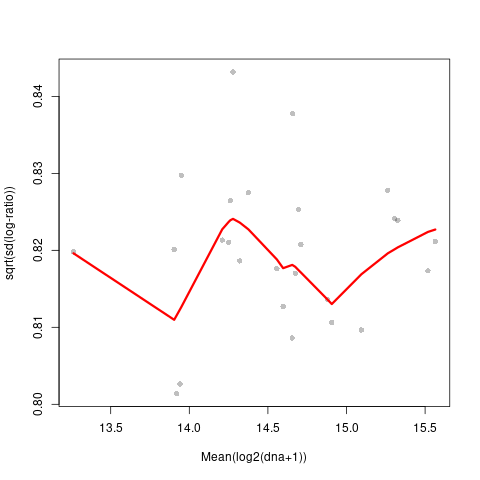

In [38]:
%%R
# we only consider BCs with at least 5 counts in plDNA (2reps x5 =10)
mpra_21= create_MPRA_tab_simple(remove_lowBCs(DFjf,c(2:3),10),2,which(colnames(DFjf)=='TF'),c(1:2))

print(head(mpra_21[[2]]))

mpra_res_21 = get_mpra_result_mod(mpra_21,c(1:2))

print(head(mpra_res_21))
print(dim(mpra_res_21))

In [40]:
%%R
write.csv(mpra_res_21,'/outpath/SE_extracted_STARRseq_MPRA_fit_res_26BS_filtered_atleast_5counts_in_plDNA_2024_09_26.csv',row.names=F)



## 5.6 library STARR-seq synthetic enhancer constructs 44 tested 


In [42]:
%%R

# load BC maps

BCi_mapf = read.csv('/path_to_map/annotated_BC_v7insert_association_Read1_read2_filtered_to_keep_only_uniquely_mapping_BCs_2023_10_07.csv',header=T)
print(head(BCi_mapf))

# load count tabs

ll=list.files('/path_to_BS_info_file/STARR_seq_v7_44insert_lib',full.names=T)
#print(ll[grep('count',ll)])
llk = ll[grep('count',ll)]
print(llk)

  X.1  X           BC
1   1  0 TGCGCTGTGATG
2   2  1 TGTCAGACAAGC
3   3  2 GGGTGCGCGTTC
4   5  4 TCTACTTCACAT
5   8  7 CTAGGTTAAGAC
6  13 12 GTGCAGTTGGGG
                                                                  R2_inserts
1 TTTGTGGTTTCATAGAAAAAGAGGAAGTGAAACATAGCAGGGAATTTCCAGGCAGTCCAGTGTACCACGTTGCA
2 TTGCGTGCCATAGAAAAAGAGGAAGTGAAACATAGCAGGGAATTTCCAGGCAGTCCAGTGTACCACGTTGGCTT
3 TGCTATTTTTAGCCATAGGAAAGTGAAAGTGAAAGTAACATAGGGGAAAGCCCCGCAGTCCAGTGTACCACGTT
4 GCTAAAAATAGAAGCAGTCCAGTGTACCACGTTGATGTGAAGTAGACTGTCTCTTATACACATCTGACGCTGCC
5 AAAAAGAGGAAGTGAAACATAGCAGGGAATTTCCAGCATAGAAAAAGAGGAAGTGAAAGCAGTCCAGTGTACCA
6 GCTAAAAATAGAACTATGGCTAAAAATAGAACTATGGCTAAAAATAGAAGCAGTCCAGTGTACCACTTTGCCCC
                                                  insert_seq insert_seq_length
1        TTTGTGGTTTCATAGAAAAAGAGGAAGTGAAACATAGCAGGGAATTTCCAG                51
2          TTGCGTGCCATAGAAAAAGAGGAAGTGAAACATAGCAGGGAATTTCCAG                49
3     TGCTATTTTTAGCCATAGGAAAGTGAAAGTGAAAGTAACATAGGGGAAAGCCCC          

In [43]:
%%R
llo = llk[c(4,1,2,3)] # first all plasmidDNA and then all 3 mRNA rep 1 to 3
DFls = lapply(llo,function(x){read.csv(x,header=T)})
sapply(DFls,dim)


ukmers = unique(unlist(lapply(DFls,function(x){x$index})))

print(length(ukmers))

DFjc = do.call(cbind,lapply(DFls,function(x){x[match(ukmers,x$index),2:3]}))
DFj = DFjc[,c(1,2,4,6,8)]
print(head(DFj))
colnames(DFj) = c('BC','plDNA',paste0('mRNA_rep',1:3))
print(head(DFj))



[1] 444112
         index  X0 X0.1 X0.2 X0.3
1 TGCGCTGTGATG 222  169  228  209
2 TGTCAGACAAGC 369   20   31   28
3 GGGTGCGCGTTC 137  199  309  291
4 CTTTTGGTTAAA 291   44   65   64
5 TCTACTTCACAT 100   59   56   82
6 CTAGGATGTAGG 278   19   30   26
            BC plDNA mRNA_rep1 mRNA_rep2 mRNA_rep3
1 TGCGCTGTGATG   222       169       228       209
2 TGTCAGACAAGC   369        20        31        28
3 GGGTGCGCGTTC   137       199       309       291
4 CTTTTGGTTAAA   291        44        65        64
5 TCTACTTCACAT   100        59        56        82
6 CTAGGATGTAGG   278        19        30        26


In [44]:
%%R
#adjust for mpra
DFjm = DFj[,c(1,2,2,2,3,4,5)]
colnames(DFjm) = c(colnames(DFj)[1],paste0('plDNA_rep',1:3),colnames(DFj)[3:5])
print(head(DFjm))


# replace NA counts with 0
for (i in 2:7){
    DFjm[is.na(DFjm[,i]),i]=0}
    
DFjf = DFjm[DFjm$BC %in% BCi_mapf$BC,]
print(head(DFjf))

print(min(DFjf$plDNA_rep2))

            BC plDNA_rep1 plDNA_rep2 plDNA_rep3 mRNA_rep1 mRNA_rep2 mRNA_rep3
1 TGCGCTGTGATG        222        222        222       169       228       209
2 TGTCAGACAAGC        369        369        369        20        31        28
3 GGGTGCGCGTTC        137        137        137       199       309       291
4 CTTTTGGTTAAA        291        291        291        44        65        64
5 TCTACTTCACAT        100        100        100        59        56        82
6 CTAGGATGTAGG        278        278        278        19        30        26
             BC plDNA_rep1 plDNA_rep2 plDNA_rep3 mRNA_rep1 mRNA_rep2 mRNA_rep3
1  TGCGCTGTGATG        222        222        222       169       228       209
2  TGTCAGACAAGC        369        369        369        20        31        28
3  GGGTGCGCGTTC        137        137        137       199       309       291
5  TCTACTTCACAT        100        100        100        59        56        82
8  CTAGGTTAAGAC        189        189        189       179 

In [45]:
%%R
## add insert ID 
DFjf$insert = BCi_mapf$insert[match(DFjf$BC,BCi_mapf$BC)]
DFjf$TF = sapply(DFjf$insert,function(x){strsplit(x,split="v7ins_")[[1]][2]})
print(head(DFjf))

print(table(is.na(DFjf$mRNA_rep3)))


             BC plDNA_rep1 plDNA_rep2 plDNA_rep3 mRNA_rep1 mRNA_rep2 mRNA_rep3
1  TGCGCTGTGATG        222        222        222       169       228       209
2  TGTCAGACAAGC        369        369        369        20        31        28
3  GGGTGCGCGTTC        137        137        137       199       309       291
5  TCTACTTCACAT        100        100        100        59        56        82
8  CTAGGTTAAGAC        189        189        189       179       292       269
13 GTGCAGTTGGGG         77         77         77        24        37        28
                 insert             TF
1  v7ins_RUNX3_PU1_TF65 RUNX3_PU1_TF65
2    v7ins_AHR_PU1_TF65   AHR_PU1_TF65
3  v7ins_MF2c_IRF2_NFK2 MF2c_IRF2_NFK2
5           v7ins_MEF2A          MEF2A
8    v7ins_PU1_TF65_PU1   PU1_TF65_PU1
13 v7ins_MF2A_MF2A_MF2A MF2A_MF2A_MF2A

FALSE 
93279 


                rep_1  rep_2  rep_3
RUNX3_PU1_TF65  37003  49692  47780
AHR_PU1_TF65   171440 217676 223550
MF2c_IRF2_NFK2  47144  64558  64478
MEF2A           42442  43863  55246
PU1_TF65_PU1   136803 197964 187551
MF2A_MF2A_MF2A  12045  16007  16582
                   logFC   AveExpr          t      P.Value    adj.P.Val
IRF2_IRF2_IRF2 -2.937699 -2.937699 -13.404669 2.840715e-23 1.249915e-21
RUNX_PU1_RUNX  -2.361237 -2.361237  -9.820971 4.191280e-16 9.220817e-15
MF2A_MF2A_MF2A -2.091977 -2.091977  -7.676606 1.054937e-11 1.547240e-10
TF65_TF65_TF65  1.912569  1.912569   6.978677 2.669152e-10 2.936067e-09
CTCF_out       -1.910661 -1.910661  -6.133275 1.195958e-08 1.052443e-07
FX1            -1.641621 -1.641621  -4.459114 1.209467e-05 8.869428e-05
                          uid stdev.unscaled (Intercept)
IRF2_IRF2_IRF2 IRF2_IRF2_IRF2      0.1405255   0.1453503
RUNX_PU1_RUNX   RUNX_PU1_RUNX      0.1347424   0.1336251
MF2A_MF2A_MF2A MF2A_MF2A_MF2A      0.1382831   0.1401259
TF65_TF65_TF65 T

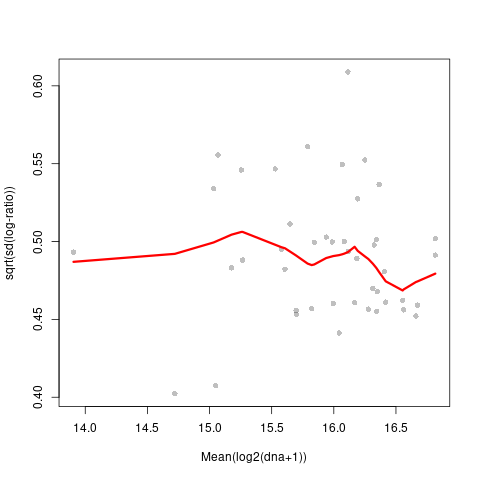

In [47]:
%%R
# consider 5 min counts for plDNA lib
mpra_v7= create_MPRA_tab_simple(remove_lowBCs(DFjf,c(2:4),15),3,which(colnames(DFjf)=='TF'),c(1:3))

print(head(mpra_v7[[2]]))

mpra_res_v7 = get_mpra_result_mod(mpra_v7,c(1:3))
print(head(mpra_res_v7))

In [49]:
%%R
write.csv(mpra_res_v7,'/outpath/MPRAlm_results/SE_extracted_STARRseq_MPRA_fit_res_v7ins_44_filtered_atleast_5counts_in_plDNA_2024_09_26.csv',row.names=F)

